![logo](./img/LogoLine_horizon_CAMS.png)

| | | |
|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=06_Profile_Plot_Zonal_Mean.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/06_Profile_Plot_Zonal_Mean.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/06_Profile_Plot_Zonal_Mean.ipynb)|

# Profile Plots and Zonal Means

This tutorial demonstrates how to visualise [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/) data of different atmospheric levels in the form of profile plots and zonal mean plots. The data used in this tutorial includes CO from the Northern Hemisphere during the summer (peak fire season) from 2003 to 2021.

In [1]:
!pip install cdsapi

In [1]:
# CDS API
import cdsapi

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.pyplot as plt

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Data access and preprocessing

### Download CAMS global reanalysis data

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads.atmosphere.copernicus.eu and obtain an API key from https://ads.atmosphere.copernicus.eu/api-how-to.)

In [4]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'

# Replace the hashtags with your key:
KEY = '##########################################'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [2]:
DATADIR = './'

For this tutorial, we will use CAMS Global Reanalysis (EAC4) data. The code below shows the subset characteristics that we will extract from this dataset as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [5]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'cams-global-reanalysis-eac4-monthly',
    {
        'variable': 'carbon_monoxide',
        'pressure_level': [
            '1', '2', '3',
            '5', '7', '10',
            '20', '30', '50',
            '70', '100', '150',
            '200', '250', '300',
            '400', '500', '600',
            '700', '800', '850',
            '900', '925', '950',
            '1000',
        ],
        'year': [
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021',
        ],
        'month': [
            '06', '07', '08',
        ],
        'product_type': 'monthly_mean',
        'area': [
            90, -180, 0,
            180,
        ],
        'format': 'netcdf',
    },
    f'{DATADIR}/CO_NHemis_JJA_2003-2021.nc')

2022-08-28 14:53:18,174 INFO Welcome to the CDS
2022-08-28 14:53:18,175 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2022-08-28 14:53:18,246 INFO Request is queued
2022-08-28 14:53:19,318 INFO Request is running
2022-08-28 14:54:33,809 INFO Request is completed
2022-08-28 14:54:33,809 INFO Downloading https://download-0004-ads-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.mars.internal-1661694806.747802-22504-9-87d9de5a-e1e5-467c-be55-1c4ff22eac9b.nc to ./DATA/CO_NHemis_JJA2003-2021.nc (157.9M)
2022-08-28 14:54:46,440 INFO Download rate 12.5M/s                                                                     


Result(content_length=165532032,content_type=application/x-netcdf,location=https://download-0004-ads-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.mars.internal-1661694806.747802-22504-9-87d9de5a-e1e5-467c-be55-1c4ff22eac9b.nc)

### Read and inspect data

Read the data into an Xarray dataset:

In [3]:
fn = f'{DATADIR}/CO_NHemis_JJA_2003-2021.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 121, level: 25, time: 57)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 2.25 1.5 0.75 0.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 700 800 850 900 925 950 1000
  * time       (time) datetime64[ns] 2003-06-01 2003-07-01 ... 2021-08-01
Data variables:
    co         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-28 13:53:29 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Representation of pressure levels

Our CO dataset represents 25 levels of the atmosphere, from 1000 (surface) to 1 hectopascals (hPa). This can be best visualised in a logarithmic scale, or if converted to altitude.

#### Pressure levels in logarithmic scale

Here we create a new coordinate of our Data Array with the logarithm of the pressure levels, to facilitate visualisation in our plots.

In [4]:
ds['level_log10'] = np.log10(ds['level'])

In [5]:
ds = ds.set_coords('level_log10')

#### Pressure levels to altitude

Here we create a new coordinate with altitude. The altitude in meters can be calculated with the international barometric formula:

H = 44330 * [1 - (P/p0)^(1/5.255) ]

Where H = altitude (m), P = measured pressure (Pa) from the sensor, and p0 = reference pressure at sea level (e.g. 1000 hPa)

Here we shall assume that the reference pressure at sea level is 1000 hPa.

In [6]:
ds['height'] = 44330. * (1 - ((ds['level']/1000.)**(1/5.255)))

We will convert the heights from meters to kilometers:

In [7]:
ds['height'] = ds['height']/1000.

Here we set the heights as a coordinate in our Xarray Dataset.

In [8]:
ds = ds.set_coords('height')

### Convert xarray Dataset into Data Array

To facilitate later processing, we will now convert this xarray Dataset into an Xarray Data Array object. This is an object which allows more options for processing data of only one variable, in this case CO.

In [9]:
da = ds['co']

In [10]:
da

<xarray.DataArray 'co' (time: 57, level: 25, latitude: 121, longitude: 480)>
[82764000 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude     (latitude) float32 90.0 89.25 88.5 87.75 ... 2.25 1.5 0.75 0.0
  * level        (level) int32 1 2 3 5 7 10 20 ... 700 800 850 900 925 950 1000
  * time         (time) datetime64[ns] 2003-06-01 2003-07-01 ... 2021-08-01
    level_log10  (level) float64 0.0 0.301 0.4771 0.699 ... 2.966 2.978 3.0
    height       (level) float64 32.42 30.74 29.65 28.16 ... 0.6528 0.4306 0.0
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide mass mixing ratio
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

### Aggregation

To facilitate visualisation of CO vertical profiles, we are going to aggregate the dataset we have downloaded both temporally and spatially.

#### Temporal aggregation

The purpose of the temporal aggregation is to average June, July and August in each year, resulting in one summer mean value at each year of the dataset.

In [11]:
summer = da.groupby('time.year').mean(keep_attrs=True)

#### Spatial aggregation

To visualise the data in a profile plot, we will aggregate over the spatial dimensions. For the latitudinal dimension, we need to take into account the variation in area as a function of latitude, which we will do by taking the cosine of the latitude as a proxy.

In [12]:
weights = np.cos(np.deg2rad(summer.latitude))
weights.name = "weights"
weighted = summer.weighted(weights)

In [13]:
# Average (mean) over the latitudinal axis
co = weighted.mean(dim=["latitude", "longitude"])

### Calculate quantiles of climatology

In [14]:
co95 = co.quantile(0.95, dim='year')
co05 = co.quantile(0.05, dim='year')
co50 = co.quantile(0.5, dim='year')

## Plot summer climatology of CO in Northern Hemisphere

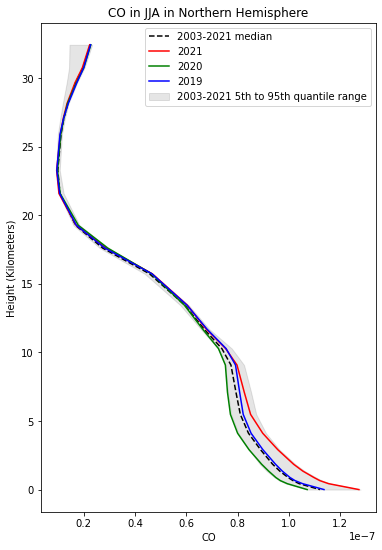

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (6, 9))

ax.set_title('CO in JJA in Northern Hemisphere', fontsize=12) # Set figure title
ax.set_ylabel('Height (Kilometers)')
ax.set_xlabel('CO')
ax.plot(co50, co50.height, color='black', linestyle='--', label='2003-2021 median')
ax.fill_betweenx(co50.height, co05, co95, alpha=0.1, color='black', label='2003-2021 5th to 95th quantile range')
ax.plot(co[18,:], co.height, color='red', linestyle='-', label='2021')
ax.plot(co[17,:], co.height, color='green', linestyle='-', label='2020')
ax.plot(co[16,:], co.height, color='blue', linestyle='-', label='2019')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

fig.savefig(f'{DATADIR}/CO_JJA_NHem_2003-2021_profile.png')

Note the distribution of CO mainly in the lower part of the atmosphere, and the high values in 2021, due mainly to the significant wildfire activity that summer.

## Create zonal mean plot of CO summer climatology in Northern Hemisphere

In [16]:
zonal = weighted.mean(dim=["longitude", "year"])

### Create zonal mean plot

C:\Users\cxcs\AppData\Local\Temp/ipykernel_13032/3827143509.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(zonal.latitude, zonal.level_log10, zonal, cmap='YlOrRd')


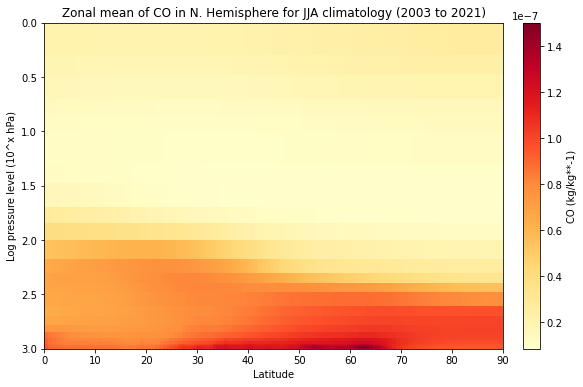

In [17]:
# Define the figure and specify size
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
# Set x and y axis tickmarks, labels and figure title
ax.set_xlabel('Latitude')
ax.set_ylabel('Log pressure level (10^x hPa)')
ax.set_title('Zonal mean of CO in N. Hemisphere for JJA climatology (2003 to 2021)', fontsize=12)
ax.invert_yaxis()

# As the presure levels (25) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax.set_aspect('auto')

# Plot the figure and specify a colourbar
im = plt.pcolormesh(zonal.latitude, zonal.level_log10, zonal, cmap='YlOrRd')
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('CO (kg/kg**-1)')

fig.savefig(f'{DATADIR}/CO_JJA_NHem_2003-2021_zonal_mean.png')

Note how at higher latitudes CO is concentrated more in the lower part of the atmosphere.